### NewsMood Analysis
- Observed trend 1: A majority of tweets, particularly those from New York Times, are quite neutral.
- Observed trend 2: Twitter sentiment is highly spreaded out, and does not have clear trend over time.
- Observed trend 3: On average, CBS has most positive sentiment, whereas CNN has most negative sentiment, over the past 100 tweets.

In [1]:
# Dependencies
import json
import tweepy
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# Import Twitter API Keys
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

### Retrieve twitter data from target user accounts

In [2]:
# Target user accounts
target_list = ['BBC', 'CBS', 'CNN', 'Fox', 'New York Times']
target_user_list = ['@BBC', '@CBS', '@CNN', '@FoxNews', '@nytimes']

In [3]:
# Preallocate twitter data
twitter_data = {}

# Loop over target user accounts
for target_user in target_user_list:

    # Get 100 tweets by the user
    public_tweets = api.user_timeline(target_user, count=100, result_type="recent")
    
    # Store twitter data
    twitter_data[target_user] = public_tweets

### Analyze twitter data for sentiment

In [4]:
# Preallocate analysis results
source_acounts = []
texts = []
dates = []
tweets_ago = []
compounds = []
positives = []
neutrals = []
negatives = []

# Analyze twitter data
for target_user, public_tweets in twitter_data.items():
    
    counter = 0
    
    for tweet in public_tweets:
        
        # Retrieve tweet info
        text = tweet['text']
        raw_time = tweet['created_at']
        date = datetime.datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y").date()
        
        # Run sentiment analysis
        results = analyzer.polarity_scores(text)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        # Store in list
        source_acounts.append(target_user)
        texts.append(text)
        dates.append(date)
        tweets_ago.append(counter)
        compounds.append(compound)
        positives.append(pos)
        neutrals.append(neu)
        negatives.append(neg)
        
        counter += 1

# Write to dataframe
df = pd.DataFrame({'source account':source_acounts, 'text':texts, 'date':dates, 'tweets ago':tweets_ago,
                  'compound score':compounds, 'positive score': positives, 'neutral score': neutrals,
                  'negative score': negatives})

In [5]:
# Format dataframe
df = df[['source account', 'text', 'date', 'tweets ago', 'compound score', 'positive score', 'neutral score',
                  'negative score']]
df.to_csv("NewsMood.csv", index=False, header=True)
df.head()

,source account,text,date,tweets ago,compound score,positive score,neutral score,negative score
0,@BBC,Women are more likely to wait longer for a hea...,2018-06-02,0,0.0000,0.000,1.000,0.000
1,@BBC,A once-in-a-lifetime conversation with Eileen ...,2018-06-02,1,0.4215,0.167,0.833,0.000
2,@BBC,Not long to go now...⚽️\n\n#HistoryWillBeMade ...,2018-06-02,2,0.0000,0.000,1.000,0.000
3,@BBC,A project to provide free sanitary products to...,2018-06-02,3,0.2960,0.135,0.779,0.086
4,@BBC,🍽️🤣 When you’re too polite to complain. https:...,2018-06-02,4,-0.3612,0.000,0.737,0.263


### Sentiment over time

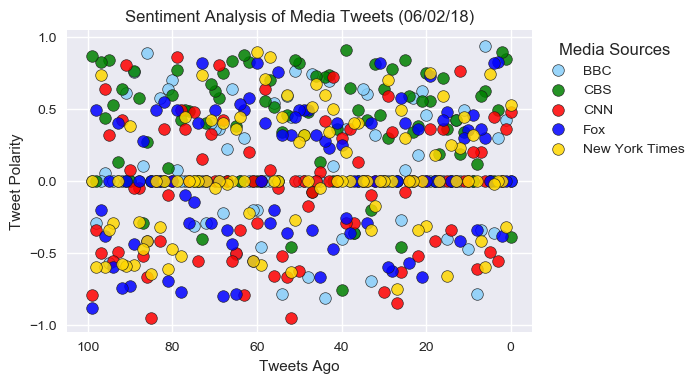

In [6]:
mpl.rcParams['figure.dpi']= 100
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
sns.set(color_codes=True)
face_colors = ['lightskyblue', 'green', 'red', 'blue', 'gold']
today_date = datetime.date.today().strftime("%m/%d/%y")

for i, label in enumerate(target_list):
    
    # Filter data
    data = df.loc[df['source account']==target_user_list[i]]
    
    # Plot
    sns.regplot(data=data, x="tweets ago", y="compound score", fit_reg=False, label=label,
                scatter_kws={'facecolors': face_colors[i], 'linewidths': 0.5, 'edgecolors': 'k', 's': 70,
                            'alpha': 0.85})


    
plt.yticks(np.arange(-1,1.5,0.5))
plt.xlim((-5, 105))
plt.ylim((-1.05, 1.05))
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.title(f'Sentiment Analysis of Media Tweets ({today_date})')
plt.legend(loc='upper left', frameon=False, markerscale = 1, title='Media Sources', bbox_to_anchor=[1,1])
plt.gca().invert_xaxis()
plt.savefig('polarity_scatter.png', bbox_inches="tight", dpi = 300)
None

### Sentiment of each account

In [7]:
# Group by twitter account
grouper = df.groupby(['source account'])
overall_score = grouper['compound score'].mean()
overall_score

source account
@BBC        0.074829
@CBS        0.341700
@CNN       -0.047412
@FoxNews    0.030712
@nytimes    0.034192
Name: compound score, dtype: float64

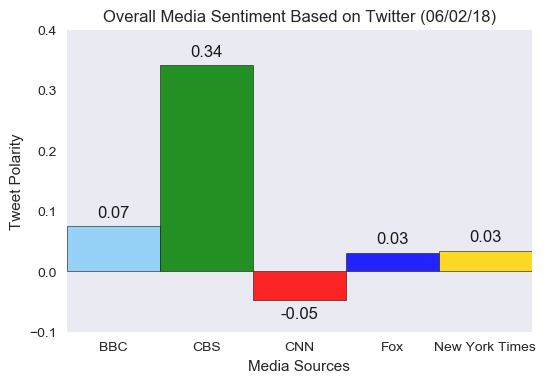

In [8]:
plt.bar(overall_score.index, overall_score.values, color = face_colors, 
        linewidth= 0.5, alpha= 0.85, edgecolor= 'k', width= 1)

plt.xticks(target_user_list, target_list)
plt.xlim((-0.5, 4.5))
plt.ylim((-0.1, 0.4))
plt.xlabel('Media Sources')
plt.ylabel('Tweet Polarity')
plt.title(f'Overall Media Sentiment Based on Twitter ({today_date})')
plt.grid(False)
None

# Add text labels
posx = range(len(target_user_list))
posy = (overall_score).values - 0.01 + 0.02 * ((overall_score).values > 0)
va = ['bottom' if (overall_score.loc[account]>0) else 'top' for account in target_user_list]
labels = overall_score.values
for i in range(len(target_user_list)):
    plt.text(posx[i], posy[i], '%1.2f' % (labels[i]), ha='center', va=va[i], color='k')
    
plt.savefig('polarity_bar.png', bbox_inches="tight", dpi = 300)